In [1]:
!pip install -U scikeras imageio imbalanced-learn --quiet

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
import tensorflow as tf

# ✅ Import thư viện
import numpy as np
import pandas as pd
from pathlib import Path
import os
import imageio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Sequential
from keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import tensorflow as tf

2025-06-01 09:00:22.482728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748768422.506485     270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748768422.513354     270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('hmnist_28_28_RGB.csv')

df_x = df.loc[:, 'pixel0000':'pixel2351']
df_y = df['label']

In [3]:
oversample = RandomOverSampler()
df_x, df_y = oversample.fit_resample(df_x, df_y)

In [4]:
df_x = np.array(df_x).reshape(-1, 28, 28, 3)

In [5]:
label_counts = df['label'].value_counts().sort_values(ascending=False)
print("Số lượng ảnh theo label:")
print(label_counts)

📊 Số lượng ảnh theo label:
label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64


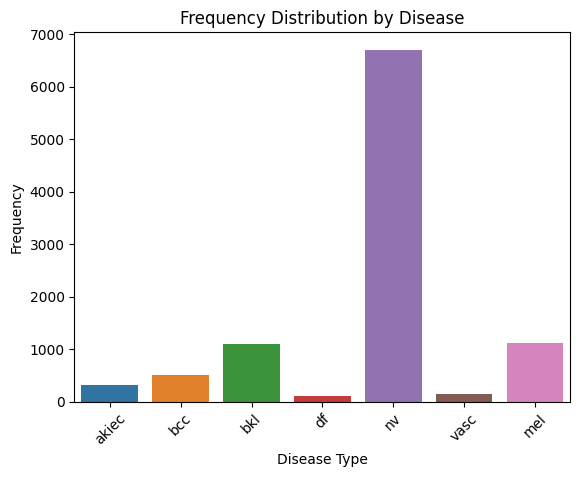

In [6]:
label_map = {0:'akiec', 1:'bcc', 2:'bkl', 3:'df', 4:'nv', 5:'vasc', 6:'mel'}
df['class_name'] = df['label'].map(label_map)

sns.countplot(x='class_name', data=df, order=label_map.values())
plt.xlabel('Disease Type')
plt.ylabel('Frequency')
plt.title('Frequency Distribution by Disease')
plt.xticks(rotation=45)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_x,df_y, test_size=0.2, random_state=1)

np_x_train = np.array(X_train)
np_x_test = np.array(X_test)
np_x_train.shape
np_x_test.shape

X_train = np.array(np_x_train).reshape(-1,28, 28,3)
X_test = np.array(np_x_test).reshape(-1,28, 28,3)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [8]:
def save_imgs(path: Path, data, labels):
    labels = np.array(labels)
    for label in np.unique(labels):
        (path / str(label)).mkdir(parents=True, exist_ok=True)
    for i in range(len(data)):
        image_path = path / str(labels[i]) / (str(i) + '.jpg')
        imageio.imsave(str(image_path), data[i].astype(np.uint8))


save_imgs(Path('/working/train'), X_train, Y_train)
save_imgs(Path('/working/test'), X_test, Y_test)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,           
    zoom_range=0.1,             
    width_shift_range=0.05,    
    height_shift_range=0.05,     
    horizontal_flip=True,      
    validation_split=0.1 
)

train_generator = train_datagen.flow_from_directory(
    '/working/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    '/working/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 33796 images belonging to 7 classes.
Found 3752 images belonging to 7 classes.


In [10]:
def build_model_alternative(fine_tune_at=100):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    base.trainable = False

    model = Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.65),
        layers.BatchNormalization(),
        layers.Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
    ])

    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# (giai đoạn 1)
model_alt = build_model_alternative()
model_alt.summary()

class_indices_map = train_generator.class_indices
print(f"Class indices: {class_indices_map}")

print("--- Training Phase 1 (Feature Extraction) ---")
history_phase1 = model_alt.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
)

I0000 00:00:1748768460.114435     270 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │          14,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,610,247 (90.07 MB)

 Trainable params: 18,439 (72.03 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

Class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
--- Training Phase 1 (Feature Extraction) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1748768473.675630     325 service.cc:148] XLA service 0x7f3c70003650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748768473.675671     325 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748768475.272345     325 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1057 ━━━━━━━━━━━━━━━━━━━━ 1:04 61ms/step - accuracy: 0.1172 - loss: 3.0213  

I0000 00:00:1748768479.518650     325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1057/1057 ━━━━━━━━━━━━━━━━━━━━ 511s 468ms/step - accuracy: 0.3933 - loss: 1.7761 - val_accuracy: 0.5693 - val_loss: 1.2288
Epoch 2/5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 490s 464ms/step - accuracy: 0.4954 - loss: 1.4197 - val_accuracy: 0.5850 - val_loss: 1.1955
Epoch 3/5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 491s 465ms/step - accuracy: 0.5001 - loss: 1.4099 - val_accuracy: 0.5906 - val_loss: 1.2093
Epoch 4/5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 475s 449ms/step - accuracy: 0.4918 - loss: 1.4166 - val_accuracy: 0.5797 - val_loss: 1.2195
Epoch 5/5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 485s 459ms/step - accuracy: 0.4965 - loss: 1.3999 - val_accuracy: 0.5925 - val_loss: 1.2096


In [11]:
# Fine-tuning (Giai đoạn 2)
model_alt.layers[0].trainable = True 
for layer in model_alt.layers[0].layers[:100]:
    layer.trainable = False

# Compile
model_alt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_alt.summary()

class_weights_dict_phase2 = {
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 1.0,  # nv
    5: 1.0,  # vasc
    6: 0.8   # mel (giảm trọng số để giảm false positive, tăng precision cho mel)
}
class_weights_dict_phase2 = {6: 0.8}


print("--- Training Phase 2 (Fine-tuning) ---")
history_phase2 = model_alt.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    class_weight=class_weights_dict_phase2 
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │          14,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,610,247 (90.07 MB)

 Trainable params: 19,471,367 (74.28 MB)

 Non-trainable params: 4,138,880 (15.79 MB)

--- Training Phase 2 (Fine-tuning) ---
Epoch 1/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 549s 482ms/step - accuracy: 0.4779 - loss: 1.4275 - val_accuracy: 0.6924 - val_loss: 0.9075
Epoch 2/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 480s 454ms/step - accuracy: 0.6467 - loss: 0.9946 - val_accuracy: 0.7655 - val_loss: 0.7174
Epoch 3/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 494s 467ms/step - accuracy: 0.7158 - loss: 0.8035 - val_accuracy: 0.8102 - val_loss: 0.6031
Epoch 4/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 493s 467ms/step - accuracy: 0.7774 - loss: 0.6495 - val_accuracy: 0.8502 - val_loss: 0.5034
Epoch 5/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 500s 473ms/step - accuracy: 0.8136 - loss: 0.5535 - val_accuracy: 0.8769 - val_loss: 0.4214
Epoch 6/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 503s 476ms/step - accuracy: 0.8525 - loss: 0.4569 - val_accuracy: 0.8971 - val_loss: 0.3530
Epoch 7/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 480s 454ms/step - accuracy: 0.8831 - loss: 0.3873 - val_accuracy: 0.9142 - val_loss: 0.3116
Epoch 8/10
1057/1057 ━━

In [12]:
model_alt.save('asets/alternative_model.h5')
import os

path = 'asets/alternative_model.h5'

if os.path.exists(path):
    print(" Model đã được lưu thành công tại:", path)
else:
    print(" Model chưa được lưu hoặc đường dẫn sai.")

✅ Model đã được lưu thành công tại: /kaggle/working/alternative_model.h5


Found 9387 images belonging to 7 classes.
294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9716 - loss: 0.1682
Alternative Model Test Accuracy: 0.9441
294/294 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step
🔍 Alternative Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1359
           1       0.96      1.00      0.98      1318
           2       0.89      0.93      0.91      1262
           3       0.99      1.00      1.00      1351
           4       0.91      0.82      0.86      1374
           5       0.99      1.00      1.00      1358
           6       0.90      0.88      0.89      1365

    accuracy                           0.94      9387
   macro avg       0.94      0.94      0.94      9387
weighted avg       0.94      0.94      0.94      9387



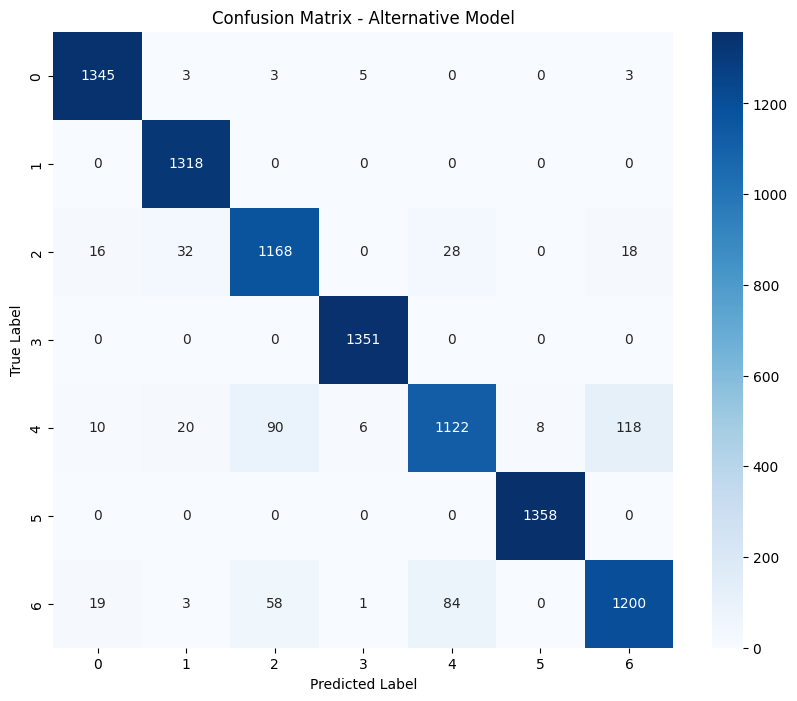

In [16]:
test_generator = test_datagen.flow_from_directory(
    '/working/test', 
    target_size=(256, 256),
    batch_size=32, 
    class_mode='categorical',
    shuffle=False
)

test_loss_alt, test_acc_alt = model_alt.evaluate(test_generator)
print(f'Alternative Model Test Accuracy: {test_acc_alt:.4f}')

y_pred_probs_alt = model_alt.predict(test_generator)
y_pred_alt = np.argmax(y_pred_probs_alt, axis=1)
y_true_alt = test_generator.classes
class_names_alt = list(test_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix
print("Alternative Model Classification Report:")
print(classification_report(y_true_alt, y_pred_alt, target_names=class_names_alt))

cm_alt = confusion_matrix(y_true_alt, y_pred_alt)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_alt, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_alt, yticklabels=class_names_alt)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Alternative Model')
plt.show()

In [1]:
# Giai đoạn 1: Feature Extraction
history_phase1 = {
    'accuracy':    [0.3933, 0.4954, 0.5001, 0.4918, 0.4965],
    'val_accuracy':[0.5693, 0.5850, 0.5906, 0.5797, 0.5925],
    'loss':        [1.7761, 1.4197, 1.4099, 1.4166, 1.3999],
    'val_loss':    [1.2288, 1.1955, 1.2093, 1.2195, 1.2096]
}

# Giai đoạn 2: Fine-tuning
history_phase2 = {
    'accuracy':    [0.4779, 0.6467, 0.7158, 0.7774, 0.8136, 0.8525, 0.8831, 0.9014, 0.9219, 0.9333],
    'val_accuracy':[0.6924, 0.7655, 0.8102, 0.8502, 0.8769, 0.8971, 0.9142, 0.9363, 0.9398, 0.9491],
    'loss':        [1.4275, 0.9946, 0.8035, 0.6495, 0.5535, 0.4569, 0.3873, 0.3291, 0.2849, 0.2474],
    'val_loss':    [0.9075, 0.7174, 0.6031, 0.5034, 0.4214, 0.3530, 0.3116, 0.2651, 0.2456, 0.2206]
}

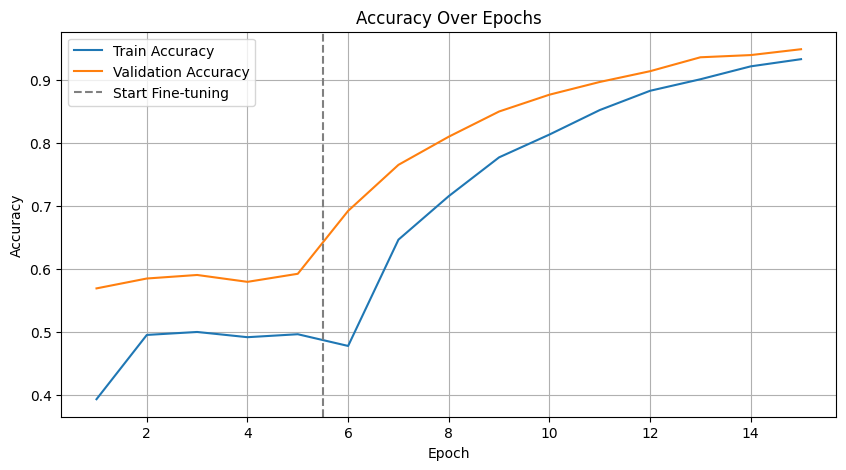

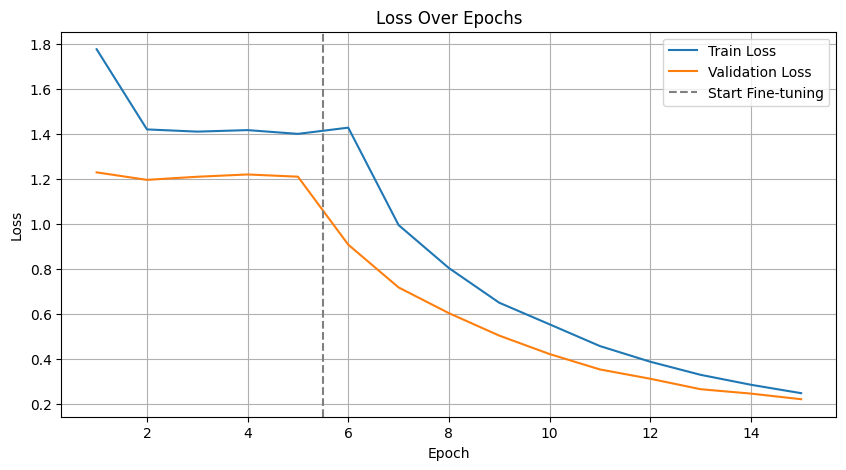

In [2]:
import matplotlib.pyplot as plt

# Nối lại
full_accuracy = history_phase1['accuracy'] + history_phase2['accuracy']
full_val_accuracy = history_phase1['val_accuracy'] + history_phase2['val_accuracy']
full_loss = history_phase1['loss'] + history_phase2['loss']
full_val_loss = history_phase1['val_loss'] + history_phase2['val_loss']

epochs = list(range(1, len(full_accuracy) + 1))

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, full_accuracy, label='Train Accuracy')
plt.plot(epochs, full_val_accuracy, label='Validation Accuracy')
plt.axvline(x=5.5, color='gray', linestyle='--', label='Start Fine-tuning')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, full_loss, label='Train Loss')
plt.plot(epochs, full_val_loss, label='Validation Loss')
plt.axvline(x=5.5, color='gray', linestyle='--', label='Start Fine-tuning')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()